<a href="https://colab.research.google.com/github/Serge3leo/temp-cola/blob/main/ruSO/1614688-pickle-%D0%B8-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D1%8B-%D0%BD%D0%B0%D1%81%D0%BB%D0%B5%D0%B4%D0%BD%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pickle и классы наследники

К моему вопросу [Сохранение состояния pickle и классы наследники](
https://ru.stackoverflow.com/q/1614688/430734).

При возникновении ситуации, когда `pickle` отказывается сохранять
(сериализовать) некоторые атрибуты, как класса наследника, так
и родительского класса (либо они сами имеют очевидные зависимости
от текущего состояния: дескрипторы открытых файлов и т.п.),
кажется предпочтительным, что бы каждый класс решал проблемы
своих собственных атрибутов самостоятельно.

Как действовать с атрибутами, которые нельзя замариновать, в случае
без наследования, описано в документации `pickle`
([Handling Stateful Objects](
https://docs.python.org/3/library/pickle.html#handling-stateful-objects),
сделать копию `__dict__`, удалить и т.п.). А в случае наследования,
как кажется, надо спуститься до основателя и, когда, все предки всё
свое сделали, то взять их результат и его доработать, только в части  
своих атрибутов.

Если я правильно понимаю, в Python функции родительского класса
работают с тем же `__dict__`, что и функции наследника. Таким
образом, код магических `__getstate__()` и `__setstate__()`
интерфейса `pickle` может выглядеть так?

In [1]:
class MySuper:
    def __getstate__(self):
        state = self.__dict__.copy()
        ...  # Удаляем то, что спасти нельзя, и добавлем "забытое".
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        ...  # Воссоздаём неспасаемое и используем дополнительно сохранённое.
    ...


class MyDerive1(MySuper):
    def __getstate__(self):
        state = super().__getstate__()
        ...  # Удаляем то, что спасти нельзя и добавлем "забытое".
        return state

    def __setstate__(self, state):
        super().__setstate__(state)
        # Такой порядок вызовов `__setstate__()` кажется удобным,
        # для исключения возможности тривиальной перезаписи
        # нетривиальных измений, сделанных родительским классом.
        # Но поскольку Python не фиксирует порядок инициализации,
        # могут быть варианты.
        ...  # Воссоздаём неспасаемое и используем дополнительно сохранённое.
    ...

В случае множественного наследования, всё станет немного запутанее,
т.к. придётся объединить исключения от мамы, папы и других
старших родствеников. Но если все они делают исключения на основе
единой таблицы `__dict__`, то это не должно стать прнципиальной
проблемой.

Я ничего не забыл? Нет ли каких подводных граблей в таком подходе?

# pickle и Matplotlib

### Импорты и несущественные настройки Jupyter

Не все GUI-бэкенды (`%matplotlib`) доступны на всех установках Jupyter,
но это не кажется проблемой, вроде как, можно сохранять для одного
бэкенда, а восстанавливать на другом.

В Colab доступны "кнопки" от `ipympl`, но на `github.dev` (Codespaces)
нет, только бэкенд `inline` с изображениями кнопок вместо них самих.
Локально вариантов больше, но это не особо влияет на суть, `pickle`
не любит "кнопки" даже в варианте `inline`.

In [2]:
%config InlineBackend.figure_format = 'retina'

# %matplotlib ipympl
# %matplotlib osx
# %matplotlib widget

if 'google.colab' in str(get_ipython().config):
    # ПРЕДУПРЕЖДЕНИЕ: При таких настройках Colab порождает `metadata.widgets`,
    # которое несовместимо со встроенным просмотром GitHub.
    # Но в остальном, они более менее нормальны, Jupyter Lab их читает.
    try:
        from google.colab import output
        output.enable_custom_widget_manager()
        %matplotlib ipympl
    except (ValueError, ModuleNotFoundError):
        %pip install -q ipympl
        print("Требуется перезапустить сеанс")
        %matplotlib ipympl

import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Пример использования

Если `test_create_serialized_states = True`, то состояние классов
сохраняется во временные файлы, после перезапуска и установки
в `False` классы (с графиками и кнопками) будет восстанавливаться
из временных файлов.

In [3]:
test_create_serialized_states = True

class MySuper:
    def __getstate__(self):
        state = self.__dict__.copy()
        # pickle не любит кнопок и т.п.
        del state['scbt']
        state['__scbt_status__'] = self.scbt.get_status()
        # Ввиду разного порядка добавления элементов,
        # размерчики могут становится немного странными.
        state['__figwidth__'] = self.fig.get_figwidth()
        state['__figheight__'] = self.fig.get_figheight()
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        self.fig.set_figwidth(state['__figwidth__'])
        self.fig.set_figheight(state['__figheight__'])
        self._MySuper_init_interface(
            scbt_actives=state['__scbt_status__'])

    def _MySuper_init_interface(self, scbt_actives=None):
        self.ax['super'].clear()  # Внезапная опытная заплатка
        self.scbt = mpl.widgets.CheckButtons(self.ax['super'],
                                             ["Super", "Hyper"],
                                             actives=scbt_actives)
        self.scbtcid = self.scbt.on_clicked(self.scbt_on_clicked)


    def __init__(self):
        self.fig, self.ax = plt.subplot_mosaic([
                                ['plt', 'super'],
                                ['plt', 'derive'],
                                ['plt', '.']],
                                width_ratios=[80, 20],
                                height_ratios=[15, 15, 70],
                            )
        self.ax['plt'].plot(np.arange(-1, 10)**2)
        self._MySuper_init_interface()
        self.scbt_cnt = 0

    def scbt_on_clicked(self, label):
        print(f"MySuper.scbt_on_clicked({label, self.scbt_cnt=})")
        self.scbt_cnt += 1


class MyDerive1(MySuper):
    def __getstate__(self):
        state = super().__getstate__()
        del state['dcbt1']
        state['__dcbt1_status__'] = self.dcbt1.get_status()
        return state

    def __setstate__(self, state):
        super().__setstate__(state)
        self._MyDerive1_init_interface(
            dcbt1_actives=state['__dcbt1_status__'])

    def _MyDerive1_init_interface(self, dcbt1_actives=None):
        self.ax['derive'].clear()  # Внезапная опытная заплатка
        self.dcbt1 = mpl.widgets.CheckButtons(self.ax['derive'],
                                              ["Derive1", "Child1"],
                                              actives=dcbt1_actives)
        self.dcbt1cid = self.dcbt1.on_clicked(self.dcbt1_on_clicked)

    def __init__(self):
        super().__init__()
        self._MyDerive1_init_interface()
        self.dcbt1_cnt = 0

    def dcbt1_on_clicked(self, label):
        print(f"MyDerive1.dcbt1_on_clicked({label, self.dcbt1_cnt=})")
        self.dcbt1_cnt += 1


class MyDerive2(MySuper):
    def __getstate__(self):
        state = super().__getstate__()
        del state['dcbt2']
        state['__dcbt2_status__'] = self.dcbt2.get_status()
        return state

    def __setstate__(self, state):
        super().__setstate__(state)
        self._MyDerive2_init_interface(
            dcbt2_actives=state['__dcbt2_status__'])

    def _MyDerive2_init_interface(self, dcbt2_actives=None):
        self.ax['derive'].clear()  # Внезапная опытная заплатка
        self.dcbt2 = mpl.widgets.CheckButtons(self.ax['derive'],
                                              ["Derive2", "Child2"],
                                              actives=dcbt2_actives)
        self.dcbt2cid = self.dcbt2.on_clicked(self.dcbt2_on_clicked)

    def __init__(self):
        super().__init__()
        self._MyDerive2_init_interface()
        self.dcbt2_cnt = 0

    def dcbt2_on_clicked(self, label):
        print(f"MyDerive2.dcbt2_on_clicked({label, self.dcbt2_cnt=})")
        self.dcbt2_cnt += 1

MySuper.scbt_on_clicked(label, self.scbt_cnt=('Super', 0))
MyDerive1.dcbt1_on_clicked(label, self.dcbt1_cnt=('Child1', 0))


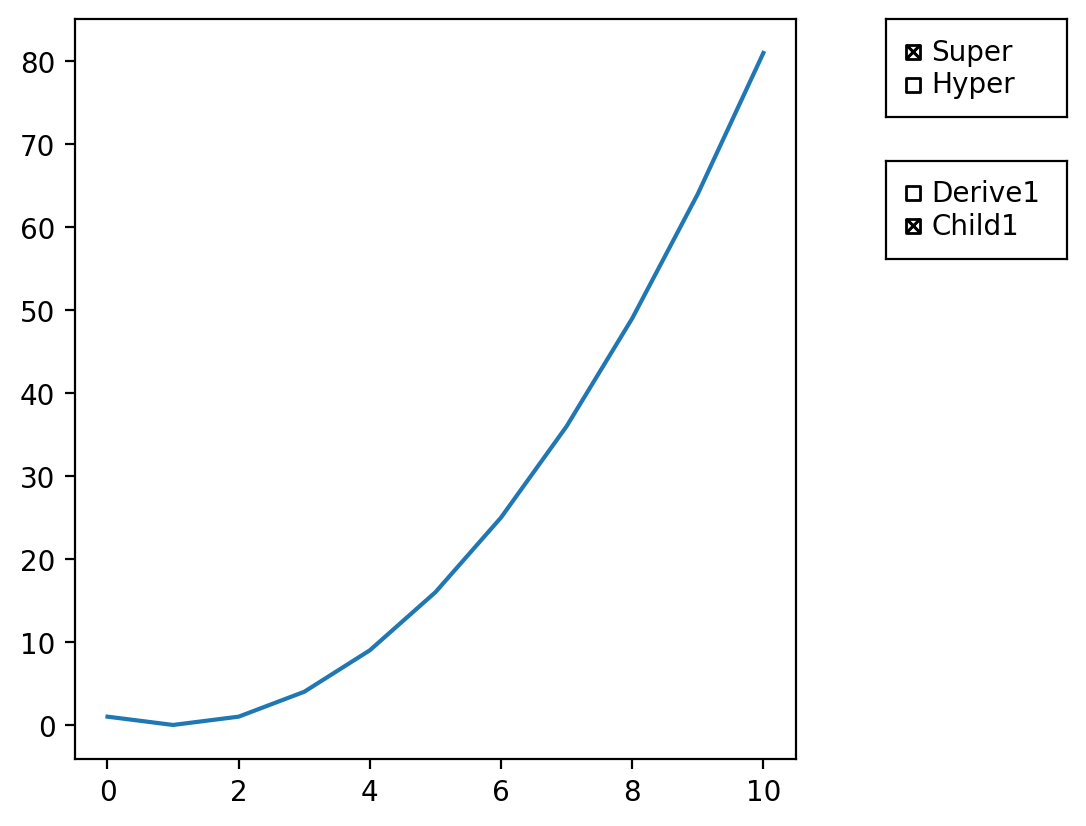

In [4]:
tfn1 = "/tmp/d1.pickle"
if test_create_serialized_states:
    d1 = MyDerive1()
    d1.scbt.set_active(0)  # Некое изменение состояния до сохранения
    d1.dcbt1.set_active(1)
    with open(tfn1, "wb") as fo:
        pickle.dump(d1, fo)
else:
    with open(tfn1, "rb") as fi:
        d1 = pickle.load(fi)
plt.show()

MySuper.scbt_on_clicked(label, self.scbt_cnt=('Hyper', 0))
MyDerive2.dcbt2_on_clicked(label, self.dcbt2_cnt=('Derive2', 0))


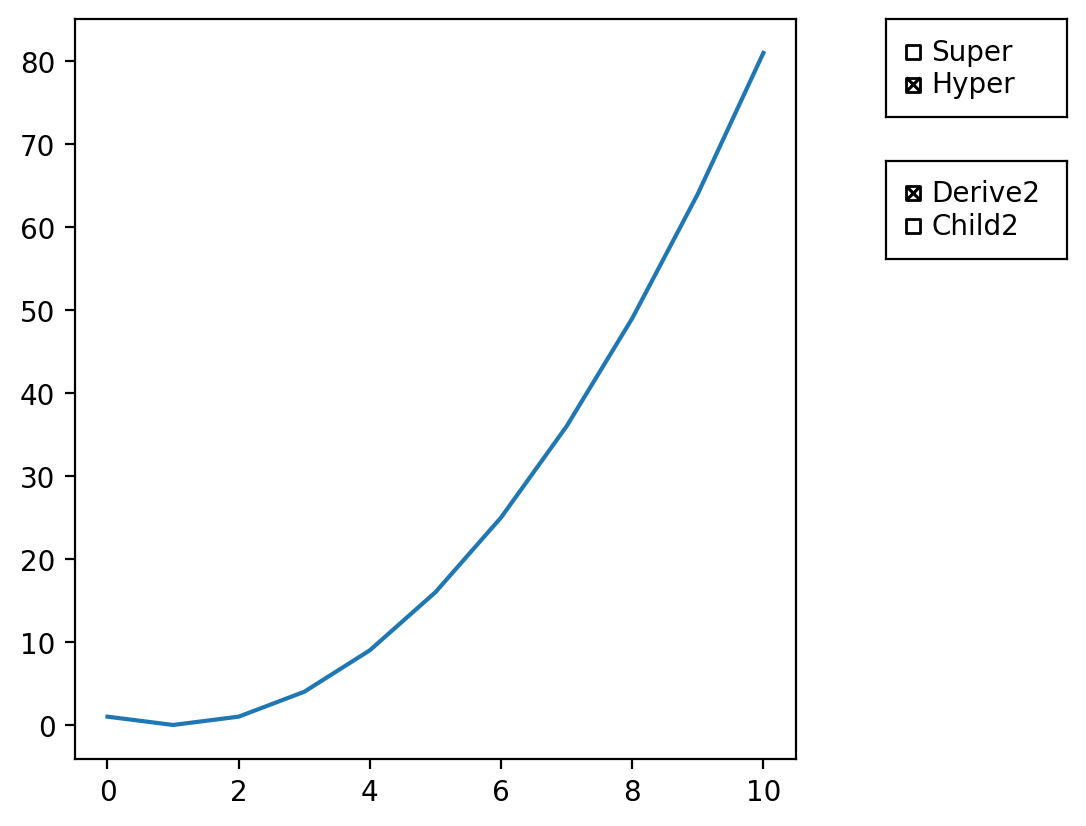

In [5]:
tfn2 = "/tmp/d2.pickle"
if test_create_serialized_states:
    d2 = MyDerive2()
    d2.scbt.set_active(1)  # Некое изменение состояния до сохранения
    d2.dcbt2.set_active(0)
    with open(tfn2, "wb") as fo:
        pickle.dump(d2, fo)
else:
    with open(tfn2, "rb") as fi:
        d2 = pickle.load(fi)
plt.show()

Вопрос вкуса, что делать с 7-ю упоминаниями "dcbt2" для каждой кнопки
или 4-мя "self.fig", возможно, стоит обернуть в отдельно. Но это уже
другой, альтернативный подход, который не факт, что лучше.

## Резюме

Мотивом рассмотрения `pickle` для сохрания состояния служит
сравнительная простота использования. К примеру, если сравнивать
со стандартным модулем `json`, то у того сразу возникают проблемы:
- `namedtuple`, вообще, полная беда;
- типы Numpy;
- пользовательские классы.

В целом, использование `json` требует немаленьких ручных доработок
(реализация функций `default()` и `object_hook()` для многих, почти
всех классов), как для классов целевого кода, так и для классов
кода отображения. Правда, можно надеяться, результат окажется более
надёжным и предсказуемым, ну, после отладки и тестирования.

Напротив, использование `pickle`, в моём случае, требует сравнительно
небольших доработок только некоторых частей кода отбражения.

Но, конечно, объём файла сохраненного состояния в `pickle` тысячи раз
больше. Кроме того у же встретились и могут ещё выскочить странные
грабли. Потому и есть вопросы. Возможно, кто-то уже насупал?

Запрос "[pickle site:matplotlib.org](https://yandex.ru/search?text=pickle+site%3Amatplotlib.org)" к Яндекс выдает некоторое
количество вопрос и ответов, но связанного изложения и/или рецепта
я не обнаружил.

# `get_pickling_errors()`

Приспособление, которое находит те атрибуты, с которыми
отказывается работать `pickle`.

In [6]:
# https://stackoverflow.com/a/7218986/8585880
def get_pickling_errors(obj, seen=None):
    if seen == None:
        seen = []
    try:
        state = obj.__getstate__()
    except AttributeError:
        return
    if state == None:
        return
    if isinstance(state, tuple):
        if not isinstance(state[0], dict):
            state = state[1]
        else:
            state = state[0].update(state[1])
    result = {}
    for i in state:
        try:
            pickle.dumps(state[i], protocol=4)
        except (TypeError, pickle.PicklingError):
            if not state[i] in seen:
                seen.append(state[i])
                result[i] = get_pickling_errors(state[i], seen)
    return result

get_pickling_errors(d1)

{}

In [7]:
get_pickling_errors(d2)

{}